In [1]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.*
!pip install stable-baselines3[extra]

!pip install gym --upgrade
!pip install gym[box2d]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,982 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 993 kB in 1s (1,475 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

import gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder

from IPython.display import HTML
from pyvirtualdisplay import Display
from base64 import b64encode
from stable_baselines3 import SAC, PPO

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)

        return True

In [3]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

#env = make_vec_env("CarRacing-v0")
env = make_vec_env("CarRacing-v1")
#env = Monitor(env, log_dir)

In [ ]:

# Separate evaluation env
eval_env = make_vec_env('CarRacing-v1')
# Use deterministic actions for evaluation
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=True, render=False)

display = Display(visible=False, size=(1400, 900))
_ = display.start()

after_training = "after_training.mp4"
model = SAC("CnnPolicy", env, verbose=1, learning_rate=0.0003, buffer_size = 10000)
#model = SAC("CnnPolicy", env, verbose=1, learning_rate = 0.0007, buffer_size=1000, batch_size = 64)
#model = PPO("CnnPolicy", env, learning_rate=0.0003, n_steps=1024, batch_size=64, n_epochs=10, gamma=0.99, gae_lambda=0.95, clip_range=0.2, seed=8)
#model = PPO.load("ppo_racing", env = env)
#model = PPO("CnnPolicy", env)
video = VideoRecorder(env, after_training)
print(env.action_space)

callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:116: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  '`env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` '


Box([-1.  0.  0.], 1.0, (3,), float32)
Track generation: 1129..1422 -> 293-tiles track
Track generation: 1121..1414 -> 293-tiles track
Track generation: 1186..1487 -> 301-tiles track
Track generation: 1151..1443 -> 292-tiles track
Track generation: 1026..1291 -> 265-tiles track
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -33.6    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1        |
|    time_elapsed    | 3471     |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -5.7     |
|    critic_loss     | 0.483    |
|    ent_coef        | 0.311    |
|    ent_coef_loss   | -5.91    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3899     |
---------------------------------
Track generation: 1169..1465 -> 296-tiles track
Track generation: 1055..1323 -> 268-tiles track
Track generation: 1064..1334 -> 270-tiles track

In [ ]:
model.save("PPO Ernest (1)")

In [7]:
import matplotlib.pyplot as plt
import numpy as np
model = SAC.load("PPO Ernest (1)", env = env)
#Validation
obs = env.reset()
rewards_data = list()

display = Display(visible=False, size=(1400, 900))
_ = display.start()
video = VideoRecorder(env, "after_training.mp4")

for i in range(5):
  cum_reward = 0
  for j in range(600):
    action, _states = model.predict(obs.copy(), deterministic=True)
    video.capture_frame()
    # env.action_space.sample() produces either 0 (left) or 1 (right).
    obs, reward, done, info = env.step(action)
    env.render()
    cum_reward += np.sum(reward)/len(reward)

    #print("step", i, observation, reward, done, info)
    if done:
      obs = env.reset()
      break
  rewards_data.append(cum_reward)

video.close()
env.close()

Wrapping the env in a VecTransposeImage.
Track generation: 1284..1610 -> 326-tiles track


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:116: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  '`env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` '


Track generation: 1057..1332 -> 275-tiles track
Track generation: 1033..1302 -> 269-tiles track
Track generation: 1087..1363 -> 276-tiles track
Track generation: 1211..1518 -> 307-tiles track


In [ ]:
def render_mp4(videopath: str) -> str:
  
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

from IPython.display import HTML
html = render_mp4(after_training)
HTML(html)

/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

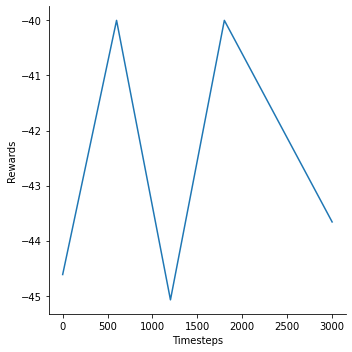

In [8]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame(data={"Timesteps": [0, 600, 1200, 1800, 3000], "Rewards": rewards_data})
sns.relplot(data=data, x="Timesteps", y="Rewards", kind="line")
plt.savefig('rewards_graph.png')

In [ ]:

'''
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    #y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

plot_results(log_dir)
'''

LoadMonitorResultsError: ignored